In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


df = pd.read_csv("..\\Data\\Timeseries_36.927_-2.374_SA2_34deg_0deg_2005_2020 (1).csv")   

# Univariated-unistep LSTM model.

We are goint to test an LSTM to predict de solar radiation from de historical solar radiation.

In [15]:
# packages for the model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.optimizers import RMSprop # Optimizer for the model (RMSprop is a good choice)    

import tensorflow as tf    

# Set the seed for reproducibility
tf.random.set_seed(1234)   

# Uncoment the following line to enable op determinism to ensure reproducibility despite parallelism
tf.config.experimental.enable_op_determinism()

## Data preprocesing



In [16]:
def train_val_test_split(serie, tr_size=0.8, vl_size=0.1, ts_size=0.1):
    # Split the data
    n = len(serie)
    n_tr = int(n*tr_size)
    n_vl = int(n*vl_size)
    n_ts = n - n_tr - n_vl
    
    train = serie[:n_tr]
    val = serie[n_tr:n_tr+n_vl]
    test = serie[n_tr+n_vl:]
    
    return train, val, test

In [17]:
df2 = df[["time", "Gr(i)"]].copy()

# pass the date to datetime
df2["time"] = pd.to_datetime(df2["time"], format='%Y%m%d:%H%M')


In [18]:
# Separete the data in train, validation and test
train, val, test = train_val_test_split(df2["Gr(i)"])

print("Train size: ", len(train))
print("Validation size: ", len(val))
print("Test size: ", len(test))


Train size:  112204
Validation size:  14025
Test size:  14027


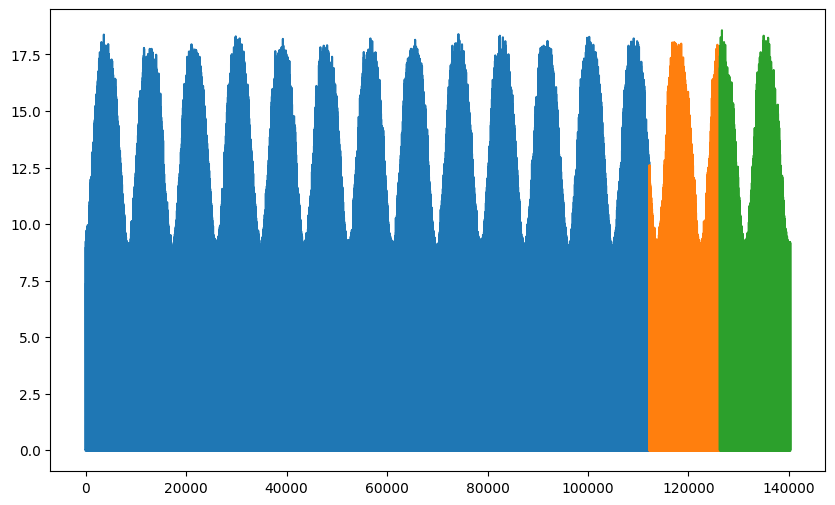

In [19]:
plt.figure(figsize=(10, 6))
plt.plot(train, label="Train")
plt.plot(val, label="Validation")
plt.plot(test, label="Test")
plt.show()

In [20]:
# Dataset creation

data = df2["Gr(i)"].values

def supervised_dataset(data, input_length, output_length):
    
    X, Y = [], []
    
    shape = data.shape
    
    if len(shape) == 1:
        rows, cols = data.shape[0], 1
        data = data.reshape(rows,cols)
    else:
        rows, cols = shape

    for i in range(rows-input_length-output_length):
        X.append(data[i:i+input_length, 0:rows])
        Y.append(data[i+input_length:i+input_length+output_length,-1].reshape(output_length,1))
    
    return np.array(X), np.array(Y)        




In [37]:
input_length = 24 * 2
output_length = 24

X_train, Y_train = supervised_dataset(train.values, input_length, output_length)
X_val, Y_val = supervised_dataset(val.values, input_length, output_length)
X_test, Y_test = supervised_dataset(test.values, input_length, output_length)


In [38]:
print("Input shape: ", X_train.shape)

print(f"Training set: x_tr: {X_train.shape}, Y_tr: {Y_train.shape}")
print(f"Validation set: x_val: {X_val.shape}, Y_val: {Y_val.shape}")
print(f"Test set: x_ts: {X_test.shape}, Y_ts: {Y_test.shape}")

Input shape:  (112132, 48, 1)
Training set: x_tr: (112132, 48, 1), Y_tr: (112132, 24, 1)
Validation set: x_val: (13953, 48, 1), Y_val: (13953, 24, 1)
Test set: x_ts: (13955, 48, 1), Y_ts: (13955, 24, 1)


In [39]:
# we have to reescale the data
from sklearn.preprocessing import MinMaxScaler

def scale_dataset(data_input):
    n_features = data_input["x_tr"].shape[2]
    
    scalers = [MinMaxScaler(feature_range=(-1,1)) for i in range(n_features)]
    
    x_tr_s = np.zeros(data_input['x_tr'].shape)
    x_vl_s = np.zeros(data_input['x_vl'].shape)
    x_ts_s = np.zeros(data_input['x_ts'].shape)
    y_tr_s = np.zeros(data_input['y_tr'].shape)
    y_vl_s = np.zeros(data_input['y_vl'].shape)
    y_ts_s = np.zeros(data_input['y_ts'].shape)

    x_tr = data_input['x_tr']
    x_vl = data_input['x_vl']
    x_ts = data_input['x_ts']
    
    y_tr = data_input['y_tr']
    y_vl = data_input['y_vl']
    y_ts = data_input['y_ts']
    
    
    for i in range(n_features):
        x_tr_s[:,:,i] = scalers[i].fit_transform(x_tr[:,:,i])
        x_vl_s[:,:,i] = scalers[i].transform(x_vl[:,:,i])
        x_ts_s[:,:,i] = scalers[i].transform(x_ts[:,:,i])
    
    y_tr_s[:,:,0] = scalers[-1].fit_transform(y_tr[:,:,0])
    y_vl_s[:,:,0] = scalers[-1].transform(y_vl[:,:,0])
    y_ts_s[:,:,0] = scalers[-1].transform(y_ts[:,:,0])

   
    data_scaled = {
        "x_tr_s": x_tr_s, "y_tr_s": y_tr_s,
        "x_vl_s": x_vl_s, "y_vl_s": y_vl_s,
        "x_ts_s": x_ts_s, "y_ts_s": y_ts_s,
        }
    return data_scaled, scalers[0]

In [40]:
data_input = {
    "x_tr": X_train, "y_tr": Y_train,
    "x_vl": X_val, "y_vl": Y_val,
    "x_ts": X_test, "y_ts": Y_test
    }

data_scaled, scaler = scale_dataset(data_input)

x_tr_s, y_tr_s = data_scaled['x_tr_s'], data_scaled['y_tr_s']
x_vl_s, y_vl_s = data_scaled['x_vl_s'], data_scaled['y_vl_s']
x_ts_s, y_ts_s = data_scaled['x_ts_s'], data_scaled['y_ts_s']

# Creating the LSTM

In [41]:
n_units = 128

input_shape = (x_tr_s.shape[1], x_tr_s.shape[2])

model = Sequential()
model.add(LSTM(n_units, input_shape=input_shape)) 
model.add(Dense(output_length, activation='linear'))

def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true)))

optimizer = RMSprop(learning_rate=5e-5)

model.compile(
    optimizer=optimizer,
    loss=rmse,
)

c:\Users\Francisco\miniconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [42]:
epochs = 10
batch_size = 30

history = model.fit(
    x = x_tr_s, y = y_tr_s,
    batch_size = batch_size,
    epochs = epochs,
    validation_data = (x_vl_s, y_vl_s),
    verbose = 1
) 

Epoch 1/10
3738/3738 ━━━━━━━━━━━━━━━━━━━━ 54s 14ms/step - loss: 0.3944 - val_loss: 0.1508
Epoch 2/10
3738/3738 ━━━━━━━━━━━━━━━━━━━━ 53s 14ms/step - loss: 0.1757 - val_loss: 0.1431
Epoch 3/10
3738/3738 ━━━━━━━━━━━━━━━━━━━━ 54s 15ms/step - loss: 0.1703 - val_loss: 0.1386
Epoch 4/10
3738/3738 ━━━━━━━━━━━━━━━━━━━━ 53s 14ms/step - loss: 0.1672 - val_loss: 0.1356
Epoch 5/10
3738/3738 ━━━━━━━━━━━━━━━━━━━━ 53s 14ms/step - loss: 0.1651 - val_loss: 0.1336
Epoch 6/10
3738/3738 ━━━━━━━━━━━━━━━━━━━━ 53s 14ms/step - loss: 0.1637 - val_loss: 0.1322
Epoch 7/10
3738/3738 ━━━━━━━━━━━━━━━━━━━━ 50s 13ms/step - loss: 0.1626 - val_loss: 0.1311
Epoch 8/10
3738/3738 ━━━━━━━━━━━━━━━━━━━━ 50s 13ms/step - loss: 0.1617 - val_loss: 0.1303
Epoch 9/10
3738/3738 ━━━━━━━━━━━━━━━━━━━━ 50s 13ms/step - loss: 0.1609 - val_loss: 0.1297
Epoch 10/10
3738/3738 ━━━━━━━━━━━━━━━━━━━━ 49s 13ms/step - loss: 0.1602 - val_loss: 0.1291


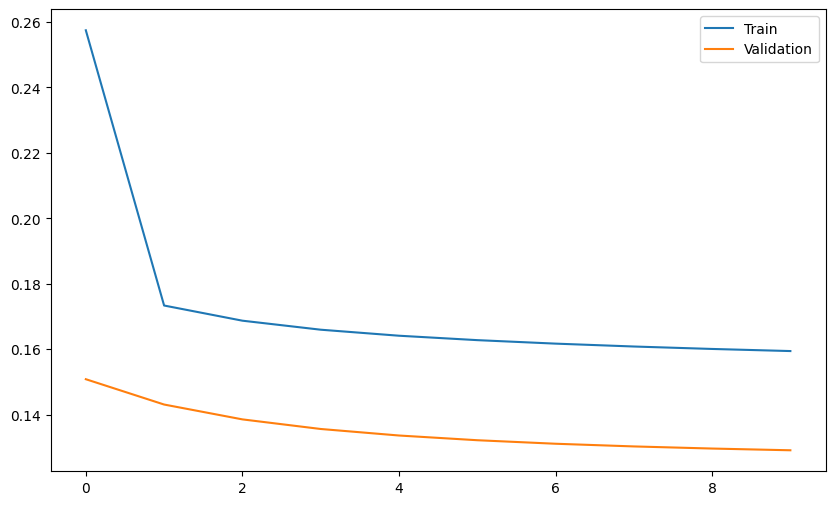

In [43]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.legend()

plt.show()

In [44]:
rmse_tr = model.evaluate(x=x_tr_s, y=y_tr_s, verbose=0)
rmse_vl = model.evaluate(x=x_vl_s, y=y_vl_s, verbose=0)
rmse_ts = model.evaluate(x=x_ts_s, y=y_ts_s, verbose=0)

In [45]:
print('comparison:')
print(f'  RMSE train:\t {rmse_tr:.3f}')
print(f'  RMSE val:\t {rmse_vl:.3f}')
print(f'  RMSE test:\t {rmse_ts:.3f}')

comparison:
  RMSE train:	 0.131
  RMSE val:	 0.130
  RMSE test:	 0.112


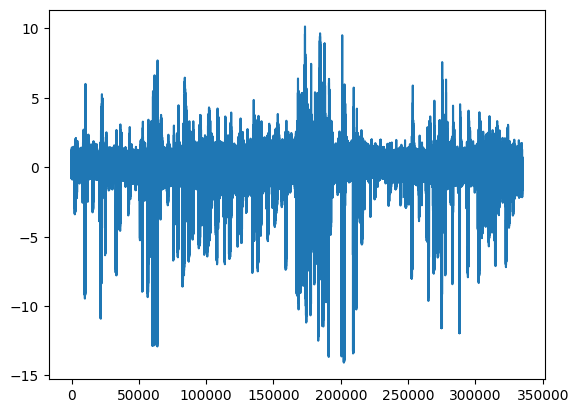

In [46]:
def predecir(x, model, scaler):
    # Calcular predicción escalada en el rango de -1 a 1
    y_pred_s = model.predict(x,verbose=0)

    # Llevar la predicción a la escala original
    y_pred = scaler.inverse_transform(y_pred_s)

    return y_pred

y_ts_pred = predecir(x_ts_s, model, scaler)
N = len(y_ts_pred)    # Número de predicciones (tamaño del set de prueba)
ndato = np.linspace(1,N,N)

# Cálculo de errores simples
errores = Y_test.flatten()-y_ts_pred.flatten()
plt.plot(errores);

(13955, 24)
[0.94708103 1.11250275 1.20897096 1.2404742  1.284362   1.28724437
 1.29437364 1.29428206 1.29471462 1.30161598 1.30483984 1.31442335
 1.318881   1.32742556 1.32252896 1.32486002 1.32247994 1.33510997
 1.33893325 1.34459348 1.35248624 1.3377631  1.3268604  1.33351841]


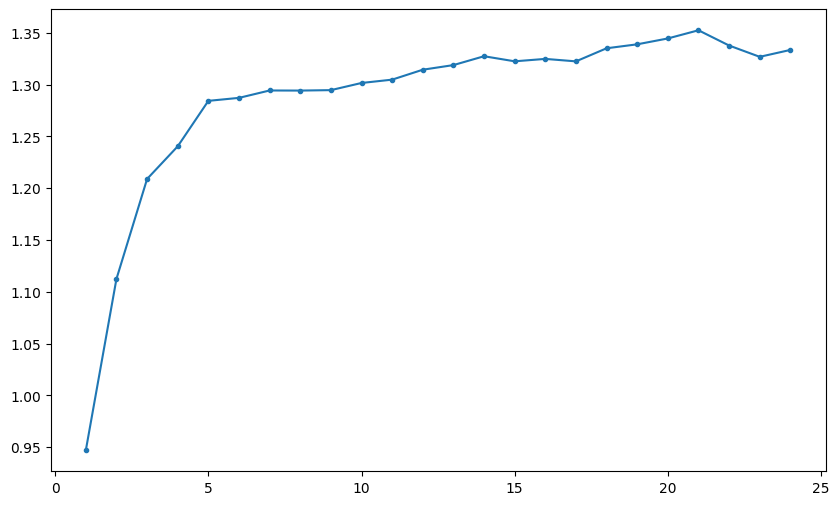

In [47]:
y_ts_pred = predecir(x_ts_s, model, scaler)
print(y_ts_pred.shape)
#y_ts_pred = scaler.inverse_transform(y_ts_pred)

diff_quad = np.square(Y_test.squeeze()-y_ts_pred)
proms = np.mean(diff_quad, axis=0)
rmse = np.sqrt(proms)
print(rmse)
t = np.linspace(1,output_length,output_length)

plt.figure(figsize=(10, 6)) 
plt.plot(t, rmse, '.-')

plt.show()

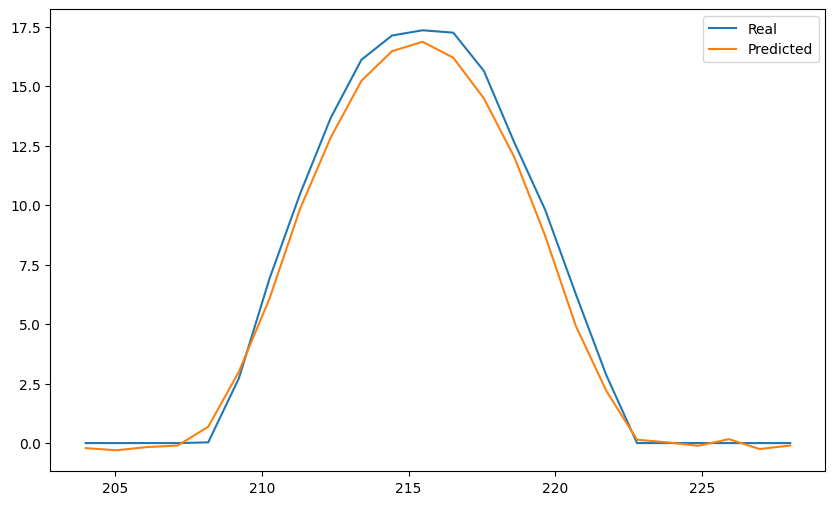

In [57]:

hour = 12 + 24 * 8
n = output_length + hour
h = np.linspace(hour,n,output_length)

plt.figure(figsize=(10, 6))
plt.plot(h,Y_test.squeeze()[hour:n,0], label='Real')

plt.plot(np.linspace(hour,n,output_length),y_ts_pred[hour, 0:n], label='Predicted')


plt.legend()
plt.show()

# Save the model

In [58]:
# model.save('oneday-uniGri.keras')